In [12]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import cvxpy as cp

# For reproducibility
np.random.seed(42)


In [13]:
# Define the list of stocks
stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

# Download historical data
data = yf.download(stocks, start='2015-01-01', end='2023-01-01')['Adj Close']

# Check the data
print(data.head())


[*********************100%%**********************]  5 of 5 completed

Ticker           AAPL     AMZN      GOOGL       MSFT       TSLA
Date                                                           
2015-01-02  24.402166  15.4260  26.447147  40.305374  14.620667
2015-01-05  23.714724  15.1095  25.943224  39.934727  14.006000
2015-01-06  23.716955  14.7645  25.302961  39.348598  14.085333
2015-01-07  24.049517  14.9210  25.228544  39.848522  14.063333
2015-01-08  24.973549  15.0230  25.316446  41.020802  14.041333


In [14]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences for LSTM
def create_sequences(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step)])
        Y.append(data[i + time_step])
    return np.array(X), np.array(Y)

time_step = 60  # 60 days look-back
X_train, Y_train = create_sequences(train_data, time_step)
X_test, Y_test = create_sequences(test_data, time_step)

# Reshape data for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])


In [15]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, len(stocks))))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=len(stocks)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=2)


Epoch 1/10


/Users/faidhi/Documents/Programming Training/WQU Capstone/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 - 2s - 35ms/step - loss: 0.0143
Epoch 2/10
49/49 - 1s - 16ms/step - loss: 0.0038
Epoch 3/10
49/49 - 1s - 17ms/step - loss: 0.0028
Epoch 4/10
49/49 - 1s - 17ms/step - loss: 0.0027
Epoch 5/10
49/49 - 1s - 17ms/step - loss: 0.0025
Epoch 6/10
49/49 - 1s - 16ms/step - loss: 0.0021
Epoch 7/10
49/49 - 1s - 16ms/step - loss: 0.0020
Epoch 8/10
49/49 - 1s - 17ms/step - loss: 0.0018
Epoch 9/10
49/49 - 1s - 17ms/step - loss: 0.0018
Epoch 10/10
49/49 - 1s - 17ms/step - loss: 0.0016


In [16]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get actual prices
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [17]:
# Calculate expected returns based on predictions
expected_returns = np.mean(test_predict, axis=0)

# Define the number of assets
n_assets = len(stocks)

# Define optimization problem
weights = cp.Variable(n_assets)
returns = expected_returns @ weights
risk = cp.quad_form(weights, np.cov(test_predict.T))

# Define constraints
constraints = [cp.sum(weights) == 1, weights >= 0]

# Define problem
problem = cp.Problem(cp.Maximize(returns - cp.norm(weights, 1) * 0.1), constraints)

# Solve problem
problem.solve()

# Get optimal weights
optimal_weights = weights.value

# Display optimal weights
portfolio_allocation = {stock: weight for stock, weight in zip(stocks, optimal_weights)}
print("Optimal Portfolio Allocation:", portfolio_allocation)


Optimal Portfolio Allocation: {'AAPL': -5.719229141026621e-09, 'MSFT': -5.663206485177682e-09, 'GOOGL': -5.892991538158663e-09, 'AMZN': 0.9999999580566407, 'TSLA': 5.921878643075292e-08}


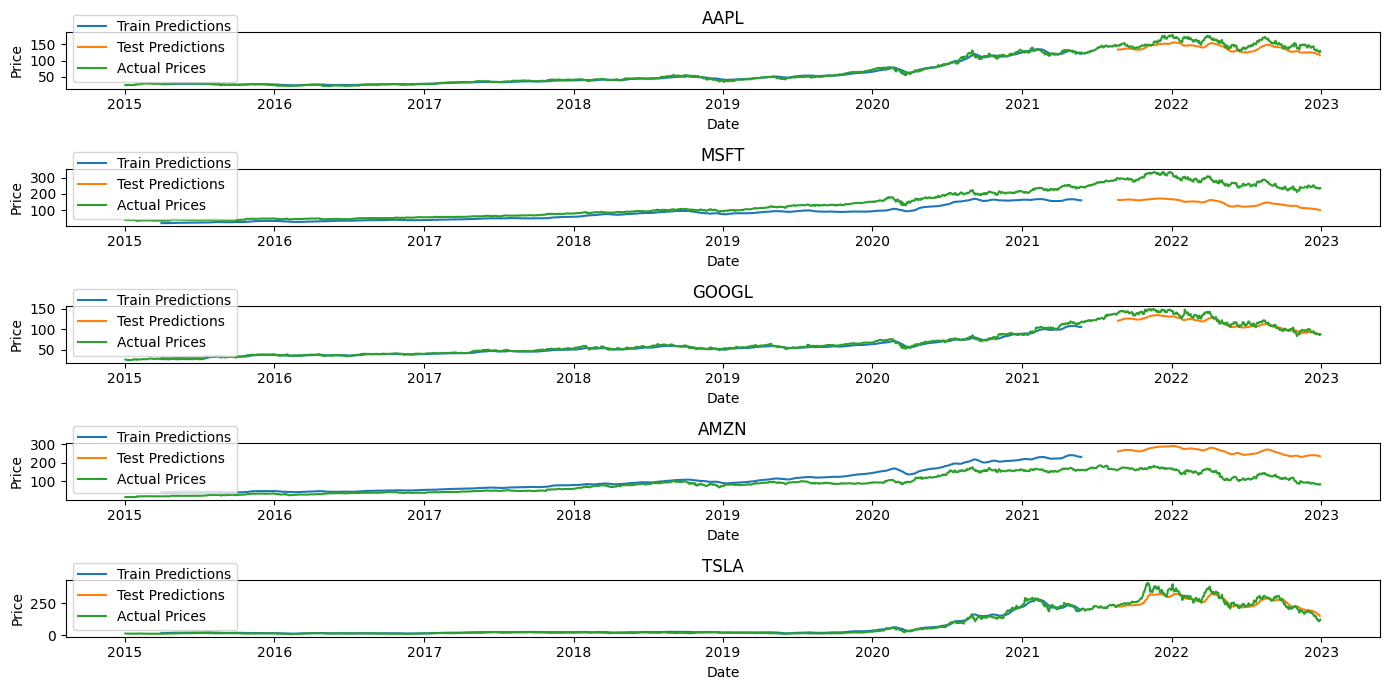

In [18]:
plt.figure(figsize=(14, 7))
for i, stock in enumerate(stocks):
    plt.subplot(len(stocks), 1, i+1)
    plt.plot(data.index[time_step:len(train_predict) + time_step], train_predict[:, i], label='Train Predictions')
    plt.plot(data.index[len(train_predict) + (time_step*2) + 1:len(scaled_data) - 1], test_predict[:, i], label='Test Predictions')
    plt.plot(data.index, data[stock], label='Actual Prices')
    plt.title(stock)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

plt.tight_layout()
plt.show()
